In [1]:
import pandas as pd
import numpy as np

import seaborn as sn
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

from math import comb
import codepub as cdp

import tqdm
import time

# Figure 1:  Algorithm statistics

**Figure-1A** Interaction between the number of peptides, the number of pools, and peptide occurrence parameters in the CPP.

In [2]:
data = pd.DataFrame(columns = ['N_pools', 'Peptide occurrence', '# of peptides'])

for n in tqdm.tqdm(range(8, 13)):
    for i in range(2, 12):
        row = pd.DataFrame({'N_pools':n, 'Peptide occurrence':i, '# of peptides':comb(n, i)}, index=[0])
        data = pd.concat([data, row])

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 440.23it/s]


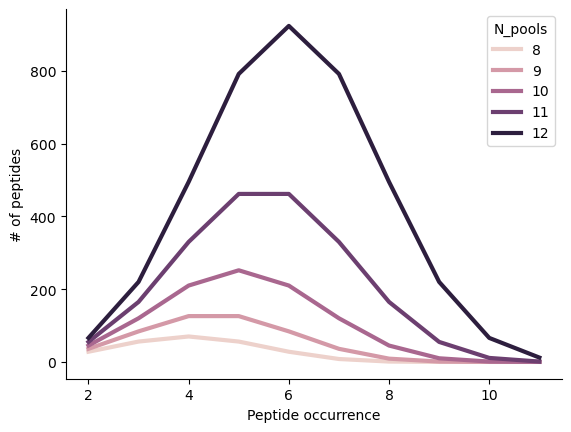

In [3]:
sn.lineplot(data = data, x='Peptide occurrence', y='# of peptides', hue = 'N_pools', linewidth = 3)
sn.despine()

**Figure-1B** Empirical runtime analyses showing that the \textit{codepub} rcBBA algorithm depends on the number of pools and peptides (displayed for constant number of pools per peptide = 4).

In [4]:
cdp.set_seed(123)

results_time_fixR4 = pd.DataFrame(columns = ['N_pools', '# of peptides', 'Time (s)'])

for n in range(15, 20):
    results_time = dict()
    for i in tqdm.tqdm(range(50, 1000, 10)):
        start_time = time.time()
        b, lines = cdp.rcbba(m=n, r=4, n=i)
        end_time = time.time()
        elapsed_time = end_time - start_time
        results_time[i] = elapsed_time
    results_time = pd.DataFrame.from_dict(results_time, orient = 'index')
    results_time = results_time.reset_index()
    results_time.columns = ['# of peptides', 'Time (s)']
    results_time['N_pools'] = n
    results_time_fixR4  = pd.concat([results_time_fixR4, results_time])

100%|███████████████████████████████████████████| 95/95 [01:01<00:00,  1.56it/s]
/var/folders/bb/6j1bt4dj4x15t9jtm7vlh6gh0000gp/T/ipykernel_10169/1293616060.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_time_fixR4  = pd.concat([results_time_fixR4, results_time])
100%|███████████████████████████████████████████| 95/95 [01:19<00:00,  1.19it/s]


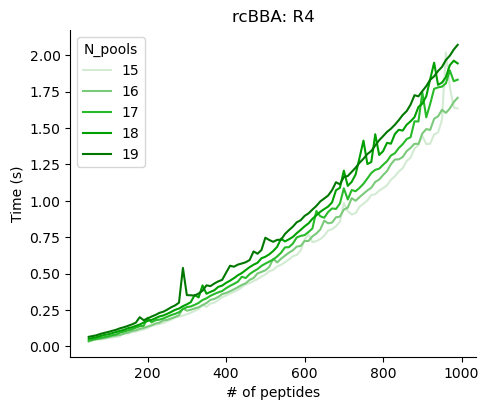

In [5]:
fig, axes = plt.subplots(figsize = (5, 4))
sn.lineplot(data = results_time_fixR4, x = '# of peptides', y = 'Time (s)', hue = 'N_pools',
           palette = ['#D3EBD3', '#7BCA7B', '#28BA28', '#00A000', '#007800'])

plt.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'
plt.title('rcBBA: R4')
sn.despine()

**Figure-1C** Deviation of \textit{codepub}-derived experimental balance ($Balance_{actual}$) from optimal balance ($Balance_{perfect}$). The difference is displayed for a simulation of 16 pools and a constant number of pools per peptide = 4. For the number of peptides $\le 50$, the BBA algorithm was applied, and for experimental setups with the number of peptides $> 50$, rcBBA was used.

In [6]:
cdp.set_seed(123)
results_balance_fixN16_fixI4 = dict()
for i in tqdm.tqdm(range(50, 1000, 100)):
    b, lines = cdp.bba(m=16, r=4, n=i)
    results_balance_fixN16_fixI4[i] = b
balance = pd.DataFrame.from_dict(results_balance_fixN16_fixI4, orient = 'index')

balance['perfect'] = 0
for i in list(balance.index):
    balance.loc[i, 'perfect'] = int(i*4/16)
    
for i in list(balance.index):
    for y in balance.columns:
        if y != 'perfect':
            balance.loc[i, y] = balance.loc[i, y] - balance.loc[i, 'perfect']


results_balance_fixN16_fixI4_rca = dict()
for i in tqdm.tqdm(range(50, 1000, 100)):
    b, lines = cdp.rcbba(m=16, r=4, n=i)
    results_balance_fixN16_fixI4_rca[i] = b  
balance_rca = pd.DataFrame.from_dict(results_balance_fixN16_fixI4_rca, orient = 'index')

balance_rca['perfect'] = 0
for i in list(balance_rca.index):
    balance_rca.loc[i, 'perfect'] = int(i*4/16)
    
for i in list(balance_rca.index):
    for y in balance_rca.columns:
        if y != 'perfect':
            balance_rca.loc[i, y] = balance_rca.loc[i, y] - balance_rca.loc[i, 'perfect']

100%|███████████████████████████████████████████| 10/10 [00:06<00:00,  1.58it/s]


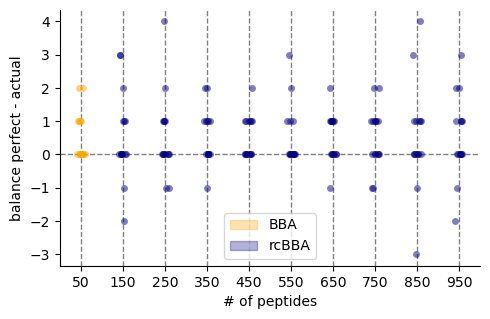

In [7]:
fig = plt.figure(figsize=(5, 6))
gs = fig.add_gridspec(nrows=2, ncols=1)
ax_scatter = fig.add_subplot(gs[1])

sn.stripplot(data=balance.drop('perfect', axis=1).T[[50]], jitter=0.1, size=5, color='#FFA500', alpha=0.5, ax=ax_scatter)
sn.stripplot(data=balance_rca.drop('perfect', axis=1).T.drop(50, axis = 1), jitter=0.1, size=5, color='#000080', alpha=0.5, ax=ax_scatter)

ax_scatter.axhline(0, ls='--', color='gray', linewidth = 1)
for x in range(10):
    ax_scatter.axvline(x, ls='--', color='gray', linewidth = 1)

ax_scatter.set_xlabel('# of peptides')
ax_scatter.set_ylabel('balance perfect - actual')

patch2 = mpatches.Patch(color='#FFA500', alpha=0.3, label='BBA')
patch1 = mpatches.Patch(color='#000080', alpha=0.3, label='rcBBA')
ax_scatter.legend(handles=[patch2, patch1], loc='lower center')

plt.tight_layout()
sn.despine()